In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
from os.path import exists
from os import remove
import sklearn.linear_model as lm
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
import sklearn.model_selection as ms
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import sys
sys.path.insert(0, "../util/")
import util as util

/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (36,40,81,87) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


# Add Dummies and Train-Test-Split

In [2]:
housingTrainWithDummiesExists = exists('../data/housingTrainWithDummies.csv')
housingTestWithDummiesExists = exists('../data/housingTestWithDummies.csv')
housingTrainWithoutDummiesExists = exists('../data/housingTrainWithoutDummies.csv')
housingTestWithoutDummiesExists = exists('../data/housingTestWithoutDummies.csv')
relatedDummiesDictionaryExists = exists('../data/relatedDummiesDictionary.json')

if (housingTrainWithDummiesExists and housingTestWithDummiesExists and
   housingTrainWithoutDummiesExists and housingTestWithoutDummiesExists and
   relatedDummiesDictionaryExists):
    housingTrainWithDummies = pd.read_csv('../data/housingTrainWithDummies.csv')
    housingTestWithDummies = pd.read_csv('../data/housingTestWithDummies.csv')
    housingTrainWithoutDummies = pd.read_csv('../data/housingTrainWithoutDummies.csv')
    housingTestWithoutDummies = pd.read_csv('../data/housingTestWithoutDummies.csv')
    with open('../data/relatedDummiesDictionary.json') as d:
        relatedDummiesDictionary = json.load(d)
    for df in [housingTrainWithDummies,housingTestWithDummies,housingTrainWithoutDummies,housingTestWithoutDummies]:
        df["MSSubClass"] = df["MSSubClass"].apply(str)
    
else:
    if (housingTrainWithDummiesExists):
        remove('../data/housingTrainWithDummies.csv')
    if (housingTestWithDummiesExists):
        remove('../data/housingTestWithDummies.csv')
    if (housingTrainWithoutDummiesExists):
        remove('../data/housingTrainWithoutDummies.csv')
    if (housingTestWithoutDummiesExists):
        remove('../data/housingTestWithoutDummies.csv')
    if (relatedDummiesDictionaryExists):
        remove('../data/relatedDummiesDictionary.json')
    
    amesHousing = pd.read_csv('../data/Ames_Housing_Price_Data.csv')   
    
    amesHousing['MSSubClass'] = amesHousing['MSSubClass'].apply(str)
    
    amesHousingCategoricalData = amesHousing.select_dtypes(include=['O'])
    for col in amesHousingCategoricalData.columns:
        amesHousing[col]=amesHousing[col].fillna('nan')
    relatedDummiesDictionary = {}
    for col in amesHousingCategoricalData.columns:
        dummyData = pd.get_dummies(amesHousing[col],prefix=col,drop_first=True)
        for dummyCol in dummyData.columns:
            relatedDummiesDictionary[str(dummyCol)] = list(dummyData.columns)
        amesHousing = pd.concat([amesHousing,dummyData],axis=1)
    with open('../data/relatedDummiesDictionary.json', 'w') as fp:
        json.dump(relatedDummiesDictionary, fp)
    
    salesPrice = amesHousing['SalePrice']
    X = amesHousing.drop(['SalePrice'], axis=1)
    
    housingTrainWithDummies, housingTestWithDummies, salesPriceTrain, salesPriceTest = train_test_split(X, salesPrice, test_size=0.2)
    
    housingTrainWithDummies['SalePrice'] = salesPriceTrain
    housingTestWithDummies['SalePrice'] = salesPriceTest
    
    dummyColumns = list(relatedDummiesDictionary.keys())
    housingTrainWithoutDummies = housingTrainWithDummies.drop(dummyColumns, axis=1)
    housingTestWithoutDummies = housingTestWithDummies.drop(dummyColumns, axis=1)
    
    housingTrainWithDummies.to_csv('../data/housingTrainWithDummies.csv')
    housingTestWithDummies.to_csv('../data/housingTestWithDummies.csv')
    housingTrainWithoutDummies.to_csv('../data/housingTrainWithoutDummies.csv')
    housingTestWithoutDummies.to_csv('../data/housingTestWithoutDummies.csv')

/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (75) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
if (("ISUDistance" not in housingTrainWithoutDummies.columns) or 
    ("ISUDistance" not in housingTrainWithDummies.columns)):
    housingTrainWithoutDummies = util.returnDFWithISUDistance(housingTrainWithoutDummies,True)
    housingTrainWithDummies["ISUDistance"] = housingTrainWithoutDummies["ISUDistance"]
    housingTrainWithDummies.to_csv('../data/housingTrainWithDummies.csv')
    housingTrainWithoutDummies.to_csv('../data/housingTrainWithoutDummies.csv')

# Training

## Linear Regression

In [4]:
housingTrainNumerical = housingTrainWithDummies.select_dtypes(include=['uint8','int64','float64'])

In [5]:
if (exists('../data/trainNanReplacementValuesDictionary.json')):
    with open('../data/trainNanReplacementValuesDictionary.json') as d:
        trainNanReplacementValuesDictionary = json.load(d)
else:
    trainNanReplacementValuesDictionary = {}
    for col in housingTrainNumerical:
        if col in ["YearBuilt","YearRemodAdd","GarageYrBlt","YrSold","ISUDistance"]:
            trainNanReplacementValuesDictionary[str(col)] = housingTrainNumerical[col].mean()
        elif col in ["OverallQual","OverallCond","MoSold"]:
            trainNanReplacementValuesDictionary[str(col)] = round(np.mean(housingTrainNumerical[col].mode().values))
        else:
            trainNanReplacementValuesDictionary[str(col)] = 0
    with open('../data/trainNanReplacementValuesDictionary.json', 'w') as fp:
        json.dump(trainNanReplacementValuesDictionary, fp)
    

In [6]:
housingTrainNumerical = util.replaceNansWithTrainingDataValues(housingTrainNumerical)

../util/util.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(trainNanReplacementValuesDictionary[str(col)])


In [7]:
salesPrice = housingTrainNumerical["SalePrice"]
X = housingTrainNumerical.drop(['SalePrice'], axis=1)

In [8]:
initialAlpha = [1]+list(np.linspace(50,1000,20))

In [9]:
grid_para_elsatic_net_initial = {'alpha': initialAlpha, 'l1_ratio': np.linspace(0,1,11)}

In [10]:
elasticNet = ElasticNet()
if False:
    grid_search_elastic_net = ms.GridSearchCV(elasticNet, grid_para_elsatic_net_initial, scoring='accuracy', cv=5, n_jobs=-1, return_train_score=True)
    grid_search_elastic_net.fit(X,salesPrice)
    grid_search_elastic_net.best_params_

In [11]:
finalAlpha = [1] + list(np.linspace(5,50,10))

In [12]:
grid_para_elsatic_net_final = {'alpha': finalAlpha, 'l1_ratio': [0.0]}

In [13]:
grid_search_elastic_net = ms.GridSearchCV(elasticNet, grid_para_elsatic_net_final, scoring='accuracy', cv=5, n_jobs=-1, return_train_score=True)
grid_search_elastic_net.fit(X,salesPrice)
grid_search_elastic_net.best_params_

/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 797266995580.6594, tolerance: 1180153387.246548
  model = cd_fast.enet_coordinate_descent(


{'alpha': 1, 'l1_ratio': 0.0}

In [14]:
if exists('../data/sigCorrDictionary.json'):
    with open('../data/sigCorrDictionary.json') as d:
        sigCorrDictionary = json.load(d)
else:
    correlationList = []
    pairList = []
    pValList = []
    for i in range(len(X.columns)):
        for j in range(len(X.columns)):
            if i<j:
                iColumn = X.columns[i]
                jColumn = X.columns[j]
                pairList.append(iColumn+'-'+jColumn)
                corrVal,pVal = stats.spearmanr(X[iColumn],
                                              X[jColumn])
                correlationList.append(corrVal)
                pValList.append(pVal)

    amesHousingCorreltaion = pd.DataFrame({"pair":pairList,
                                    "corr":correlationList,
                                    "pVal":pValList
                                   },columns=["pair","corr","pVal"]).sort_values(by=["pVal","corr"],
                                                                                 ascending=[True,False])

    amesHousingSigCorrs = amesHousingCorreltaion[(np.isnan(amesHousingCorreltaion['pVal'])==False) & (amesHousingCorreltaion['pVal'] < 0.05)]
    absRValues = abs(amesHousingSigCorrs['corr'])
    amesHousingSigCorrs = amesHousingSigCorrs[abs(amesHousingSigCorrs['corr']) > absRValues.quantile(.975)]

    sigCorrDictionary = {}
    for col in X.columns:
        correlatedRelations = (amesHousingSigCorrs[amesHousingSigCorrs['pair'].str.contains(col)])["pair"]
        correlatedColumns = [name.replace("-","").replace(col,"") for name in correlatedRelations]
        relatedDummies = []
        for corrCol in correlatedColumns:
            if corrCol in relatedDummiesDictionary.keys():
                relatedDummies = relatedDummies + relatedDummiesDictionary[corrCol]
        correlatedColumns = list(set(correlatedColumns + relatedDummies))
        sigCorrDictionary[col] = correlatedColumns
    with open('../data/sigCorrDictionary.json', 'w') as fp:
        json.dump(sigCorrDictionary, fp)

In [15]:
baseV1 = pd.DataFrame()
prebaseV2 = pd.DataFrame()
baseV2 = pd.DataFrame()

linmodel = lm.LinearRegression()
linmodel.fit(np.log(X[['GrLivArea']]),np.log(salesPrice))
baseV1[f'GrLivArea^{round(linmodel.coef_[0],2)}'] = X['GrLivArea'] ** round(linmodel.coef_[0],2)

linmodel = lm.LinearRegression()
XWithNeighborhood = pd.merge(X,housingTrainWithDummies[["PID","Neighborhood"]],how='left', left_on='PID', right_on='PID')
Nbr_quantile = XWithNeighborhood.groupby('Neighborhood')['GrLivArea'].quantile(0.8)
joint_Nbr_quantile = pd.merge(XWithNeighborhood[['Neighborhood']], Nbr_quantile, how='left', left_on='Neighborhood', right_index=True)
smaller_home = XWithNeighborhood.GrLivArea < joint_Nbr_quantile.GrLivArea

small = []
large = []
for i,isSmall in enumerate(smaller_home):
    if isSmall:
        small.append(XWithNeighborhood.GrLivArea[i])
        large.append(0)
    else:
        small.append(0)
        large.append(XWithNeighborhood.GrLivArea[i])
linmodel.fit(np.log(XWithNeighborhood[["GrLivArea"]])[smaller_home],np.log(salesPrice)[smaller_home.values])
baseV2[f'smallGrLivArea^{round(linmodel.coef_[0],2)}'] = small ** round(linmodel.coef_[0],2)
linmodel.fit(np.log(XWithNeighborhood[["GrLivArea"]])[~smaller_home],np.log(salesPrice)[~smaller_home.values])
baseV2[f'largeGrLivArea^{round(linmodel.coef_[0],2)}'] = large ** round(linmodel.coef_[0],2)

In [16]:
elasticNet = ElasticNet(alpha=1000,l1_ratio=0.0)
results = cross_validate(elasticNet,baseV1,salesPrice)
np.mean(results['test_score'])

/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2258475231667.5415, tolerance: 933121559.0304306
  model = cd_fast.enet_coordinate_descent(
/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2213165450121.7876, tolerance: 933224897.8421112
  model = cd_fast.enet_coordinate_descent(
/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2374646029616.0728, tolerance: 966845617.2990716
  model = cd_fast.enet_coordinate_descent(
/Users/garysimmons/opt/anaconda3/lib/python3.8/site-

0.5325034775137362

In [17]:
elasticNet = ElasticNet(alpha=1000,l1_ratio=0.5)
results = cross_validate(elasticNet,baseV2,salesPrice)
np.mean(results['test_score'])

0.5809009293889638

In [18]:
availabilityList = list(X.columns)

In [19]:
availabilityList = util.removeDummiesAndCorrelatedFeaturesFromAvailabilityList(availabilityList,"GrLivArea")

In [20]:
f_value,p_value = f_regression(X,salesPrice)
fValuesSorted = pd.DataFrame({"colName":list(X.columns),
                             "f_value":f_value},
                            columns=["colName","f_value"]).sort_values(by=["f_value"],
                                                                                 ascending=[False])

/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [21]:
xTrain = baseV2
elasticNet = ElasticNet(alpha=1000,l1_ratio=0.5)
results = cross_validate(elasticNet,xTrain,salesPrice,return_train_score=True)
trainScore = np.mean(results['train_score'])
testScore = np.mean(results['test_score'])
bestScore = testScore
modelEvolution = pd.DataFrame({"features":["\n".join(list(xTrain.columns))],
                              "train_score":[trainScore],
                              "test_score":[testScore],
                              "test_score_lift":[0.0]},
                             columns = ["features","train_score","test_score","test_score_lift"])
util.pretty_print(modelEvolution)

,features,train_score,test_score,test_score_lift
0,smallGrLivArea^1.0largeGrLivArea^1.24,0.583105,0.580901,0.0


In [22]:
!rm -r ../images/normalCheck
!rm -r ../images/isHeteroskedastic
!rm -r ../images/isHomoSkedastic
!rm -r ../images/notCentered

!mkdir ../images/normalCheck
!mkdir ../images/isHeteroskedastic
!mkdir ../images/isHomoSkedastic
!mkdir ../images/notCentered

In [23]:
diverseNumbers = [col for col in fValuesSorted.colName if (col not in relatedDummiesDictionary.keys() and len(list(set(X[col].values))) > 15)]
nonDiverseNumbers = [col for col in fValuesSorted.colName if (col not in relatedDummiesDictionary.keys() and len(list(set(X[col].values))) <= 15)]
dummyColumns = [col for col in fValuesSorted.colName if col in relatedDummiesDictionary.keys()]
prioritizedList = diverseNumbers + nonDiverseNumbers + dummyColumns

In [24]:
for i,col in enumerate(prioritizedList):
    if col in availabilityList:
        if col in relatedDummiesDictionary.keys():
            #print(f'{i*100.0/len(fValuesSorted.colName)}% complete. Sorting {col}')
            newX = pd.concat([xTrain,X[relatedDummiesDictionary[col]]],axis=1)
        else:
            #print(f'{i*100.0/len(fValuesSorted.colName)}% complete. Computing {col}')
            valueSet = list(set(X[col].values))
            if (len(valueSet) <= 15):
                newX = util.engineerSmallFeature(xTrain,X[col],salesPrice,str(col))
            elif util.IsHomoskedastic(X[col],salesPrice,str(col)):
                newX = xTrain.copy()
                newX[col] = X[col]
            else:
                newX = util.engineerFeature(xTrain,X[col],salesPrice,str(col))
        if (type(newX) != type(None)):
            elasticNet = ElasticNet(alpha=1000,l1_ratio=0.5)
            results = cross_validate(elasticNet,newX,salesPrice,return_train_score=True)
            trainScore = np.mean(results['train_score'])
            testScore = np.mean(results['test_score'])
            if testScore > bestScore:
                scoreLift = testScore - bestScore
                bestScore = testScore
                xTrain = newX
                newModel = pd.DataFrame({"features":["\n".join(list(xTrain.columns))],
                              "train_score":[trainScore],
                              "test_score":[testScore],
                              "test_score_lift":[scoreLift]},
                             columns = ["features","train_score","test_score","test_score_lift"])
                modelEvolution = pd.concat([modelEvolution,newModel],axis=0)
                availabilityList = util.removeDummiesAndCorrelatedFeaturesFromAvailabilityList(availabilityList,col)
print('100% complete!')
modelEvolution.reset_index()
util.pretty_print(newModel)

../util/util.py:155: RuntimeWarning: divide by zero encountered in power
  xPow = newX ** power
../util/util.py:155: RuntimeWarning: divide by zero encountered in power
  xPow = newX ** power


100% complete!


,features,train_score,test_score,test_score_lift
0,smallGrLivArea^1.0largeGrLivArea^1.24BsmtUnfSFScreenPorchEnclosedPorchISUDistanceLowQualFinSFBsmtFinSF2BsmtFullBathOverallCondKitchenAbvGr_invbc_l-0.03_m-0.16_b10.25BsmtHalfBath^0.19PoolArea_invbc_l-0.03_m0.0_b10.09MoSold_invbc_l-0.03_m0.0_b10.07YrSoldExterQual_FaExterQual_GdExterQual_TANeighborhood_BluesteNeighborhood_BrDaleNeighborhood_BrkSideNeighborhood_ClearCrNeighborhood_CollgCrNeighborhood_CrawforNeighborhood_EdwardsNeighborhood_GilbertNeighborhood_GreensNeighborhood_GrnHillNeighborhood_IDOTRRNeighborhood_LandmrkNeighborhood_MeadowVNeighborhood_MitchelNeighborhood_NAmesNeighborhood_NPkVillNeighborhood_NWAmesNeighborhood_NoRidgeNeighborhood_NridgHtNeighborhood_OldTownNeighborhood_SWISUNeighborhood_SawyerNeighborhood_SawyerWNeighborhood_SomerstNeighborhood_StoneBrNeighborhood_TimberNeighborhood_VeenkerMasVnrType_BrkFaceMasVnrType_NoneMasVnrType_StoneMasVnrType_nanBsmtExposure_GdBsmtExposure_MnBsmtExposure_NoBsmtExposure_nanGarageType_AttchdGarageType_BasmentGarageType_BuiltInGarageType_CarPortGarageType_DetchdGarageType_nanHeatingQC_FaHeatingQC_GdHeatingQC_PoHeatingQC_TALotShape_IR2LotShape_IR3LotShape_RegMSZoning_C (all)MSZoning_FVMSZoning_I (all)MSZoning_RHMSZoning_RLMSZoning_RMPavedDrive_PPavedDrive_YGarageCond_FaGarageCond_GdGarageCond_PoGarageCond_TAGarageCond_nanRoofStyle_GableRoofStyle_GambrelRoofStyle_HipRoofStyle_MansardRoofStyle_ShedCentralAir_YSaleType_CWDSaleType_ConSaleType_ConLDSaleType_ConLISaleType_ConLwSaleType_NewSaleType_OthSaleType_VWDSaleType_WD Electrical_FuseFElectrical_FusePElectrical_SBrkrElectrical_nanFence_GdWoFence_MnPrvFence_MnWwFence_nanLandContour_HLSLandContour_LowLandContour_LvlBsmtCond_FaBsmtCond_GdBsmtCond_PoBsmtCond_TABsmtCond_nanLotConfig_CulDSacLotConfig_FR2LotConfig_FR3LotConfig_InsideExterCond_FaExterCond_GdExterCond_PoExterCond_TACondition1_FeedrCondition1_NormCondition1_PosACondition1_PosNCondition1_RRAeCondition1_RRAnCondition1_RRNeCondition1_RRNnFunctional_Maj2Functional_Min1Functional_Min2Functional_ModFunctional_SalFunctional_TypAlley_PaveAlley_nanMiscFeature_OthrMiscFeature_ShedMiscFeature_TenCMiscFeature_nan,0.638119,0.630646,1.568221e-09


In [25]:
modelEvolution

,features,train_score,test_score,test_score_lift
0,smallGrLivArea^1.0\nlargeGrLivArea^1.24,0.583105,0.580901,0.000000e+00
0,smallGrLivArea^1.0\nlargeGrLivArea^1.24\nBsmtU...,0.584311,0.581405,5.037254e-04
0,smallGrLivArea^1.0\nlargeGrLivArea^1.24\nBsmtU...,0.586130,0.582765,1.360132e-03
0,smallGrLivArea^1.0\nlargeGrLivArea^1.24\nBsmtU...,0.601704,0.596666,1.390130e-02
0,smallGrLivArea^1.0\nlargeGrLivArea^1.24\nBsmtU...,0.601705,0.596667,7.921900e-07
0,smallGrLivArea^1.0\nlargeGrLivArea^1.24\nBsmtU...,0.609615,0.603503,6.835953e-03
0,smallGrLivArea^1.0\nlargeGrLivArea^1.24\nBsmtU...,0.610525,0.604000,4.973558e-04
0,smallGrLivArea^1.0\nlargeGrLivArea^1.24\nBsmtU...,0.610571,0.604046,4.613115e-05
0,smallGrLivArea^1.0\nlargeGrLivArea^1.24\nBsmtU...,0.610572,0.604047,4.840611e-07
0,smallGrLivArea^1.0\nlargeGrLivArea^1.24\nBsmtU...,0.637872,0.630399,2.635245e-02


In [26]:
linmodel = lm.LinearRegression()
linmodel.fit(xTrain,salesPrice)
fitValues = [linmodel.intercept_] + list(linmodel.coef_)
features = ["intercept"] + list(xTrain.columns)
modelDescription = pd.DataFrame({"features":features,
                                "fitValues":fitValues}
                                ,columns=["features","fitValues"])
print(modelDescription)
linmodel.score

                features     fitValues
0              intercept  7.123694e+16
1     smallGrLivArea^1.0  7.702459e+01
2    largeGrLivArea^1.24  1.231206e+01
3              BsmtUnfSF  1.025921e+00
4            ScreenPorch  4.471064e+01
..                   ...           ...
134            Alley_nan  6.585322e+03
135     MiscFeature_Othr  7.810626e+03
136     MiscFeature_Shed -7.910611e+03
137     MiscFeature_TenC  0.000000e+00
138      MiscFeature_nan -2.673034e+03

[139 rows x 2 columns]


<bound method RegressorMixin.score of LinearRegression()>

## Random Forest

In [27]:
housingTrainNumerical = housingTrainWithDummies.select_dtypes(include=['uint8','int64','float64'])
housingTrainNumerical = util.replaceNansWithTrainingDataValues(housingTrainNumerical)

../util/util.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(trainNanReplacementValuesDictionary[str(col)])


In [28]:
treeSalesPrice = housingTrainNumerical["SalePrice"]
treeXTrain = housingTrainNumerical.drop(["SalePrice"],axis=1)
regr = RandomForestRegressor()
params = {'n_estimators': 1000, 'max_depth': 20, 'max_features': None}

In [29]:
try:
    params["n_estimators"]
except BaseException:
    bestScore = 0.0
    nValues = [100,500,1000]
    for n in nValues:
        regr = RandomForestRegressor(n_estimators = n)
        results = cross_validate(regr,treeXTrain,treeSalesPrice)
        if np.mean(results["test_score"]) > bestScore:
            bestScore = np.mean(results["test_score"])
            params["n_estimators"] = n


In [30]:
try:
    params["max_depth"]
except BaseException:
    bestScore = 0.0
    depthValues = [10,20,None]
    for depth in depthValues:
        regr = RandomForestRegressor(n_estimators = params["n_estimators"],
                                    max_depth = depth)
        results = cross_validate(regr,treeXTrain,treeSalesPrice)
        if np.mean(results["test_score"]) > bestScore:
            bestScore = np.mean(results["test_score"])
            params["max_depth"] = depth

In [31]:
try:
    params["max_features"]
except BaseException:
    bestScore = 0.0
    nFeatureValues = ['sqrt','log2',None]
    for nFeatures in nFeatureValues:
        regr = RandomForestRegressor(n_estimators = params["n_estimators"],
                                    max_depth = params["max_depth"],
                                    max_features = nFeatures)
        results = cross_validate(regr,treeXTrain,treeSalesPrice)
        if np.mean(results["test_score"]) > bestScore:
            bestScore = np.mean(results["test_score"])
            params["max_features"] = nFeatures

In [32]:
print(params)
regr = RandomForestRegressor(n_estimators=params["n_estimators"],
                            max_depth = params["max_depth"],
                            max_features = params["max_features"])
regr.fit(treeXTrain,treeSalesPrice)
regr.score(treeXTrain,treeSalesPrice)

{'n_estimators': 1000, 'max_depth': 20, 'max_features': None}


0.9869697487211483

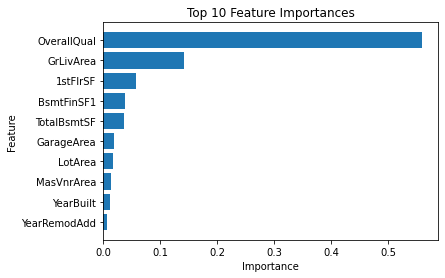

In [33]:
featureImportance = pd.DataFrame({"feature":treeXTrain.columns,
                                 "featureImportance":regr.feature_importances_},
                                columns = ["feature","featureImportance"])
featureImportanceSorted = featureImportance.sort_values(by="featureImportance")
topFeatureImportances = featureImportanceSorted.tail(10)
plt.figure()
plt.barh(topFeatureImportances["feature"], topFeatureImportances["featureImportance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances")
plt.savefig("../images/TreeFeatureImportances.png")

# Testing

In [34]:
if (("ISUDistance" not in housingTestWithoutDummies.columns) or 
    ("ISUDistance" not in housingTestWithDummies.columns)):
    housingTestWithoutDummies = util.returnDFWithISUDistance(housingTestWithoutDummies,True)
    housingTestWithDummies["ISUDistance"] = housingTestWithoutDummies["ISUDistance"]
    housingTestWithDummies.to_csv('../data/housingTestWithDummies.csv')
    housingTestWithoutDummies.to_csv('../data/housingTestWithoutDummies.csv')

In [35]:
housingTestNumerical = housingTestWithDummies.select_dtypes(include=['uint8','int64','float64'])
housingTestNumerical = util.replaceNansWithTrainingDataValues(housingTestNumerical)

../util/util.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(trainNanReplacementValuesDictionary[str(col)])


In [36]:
housingTestLinear = housingTestNumerical.copy()
housingTestForest = housingTestNumerical.copy()

## Linear Regression

In [37]:
housingTestLinear = pd.merge(housingTestLinear,housingTestWithDummies[["PID","Neighborhood"]],how='left', left_on='PID', right_on='PID')
joint_Nbr_quantile = pd.merge(housingTestLinear[['Neighborhood']], Nbr_quantile, how='left', left_on='Neighborhood', right_index=True)
smaller_home = housingTestLinear.GrLivArea < joint_Nbr_quantile.GrLivArea

small = []
large = []
for i,isSmall in enumerate(smaller_home):
    if isSmall:
        small.append(housingTestLinear.GrLivArea[i])
        large.append(0)
    else:
        small.append(0)
        large.append(housingTestLinear.GrLivArea[i])

housingTestLinear["smallGrLivArea^1.0"] = np.array(small) ** 1.0

housingTestLinear["largeGrLivArea^1.24"] = np.array(large) ** 1.24

In [38]:
xTest = housingTestLinear[["smallGrLivArea^1.0","largeGrLivArea^1.24"]]
xTrainColumns = xTrain.columns
for col in xTrainColumns:
    if (col in housingTestLinear.columns):
        xTest[col] = housingTestLinear[col]
    elif str(col) == 'KitchenAbvGr_invbc_l-0.03_m-0.16_b10.25':
        xTest[col] = util.InvBoxCox(housingTestLinear['KitchenAbvGr'],
                                   -0.03,-0.16,10.25)
    elif str(col) == 'BsmtHalfBath^0.19':
        xTest[col] = housingTestLinear['BsmtHalfBath'] ** 0.19
    elif str(col) == 'PoolArea_invbc_l-0.03_m0.0_b10.09':
        xTest[col] = util.InvBoxCox(housingTestLinear['PoolArea'],
                                   -0.03,0.0,10.09)
    elif str(col) == 'MoSold_invbc_l-0.03_m0.0_b10.07':
        xTest[col] = util.InvBoxCox(housingTestLinear['MoSold'],
                                   -0.03,0.0,10.07) 
    else:
        print(f'{col} not in housingTestLinear')
        break

<ipython-input-38-8e72c4e040c9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xTest[col] = housingTestLinear[col]
<ipython-input-38-8e72c4e040c9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xTest[col] = util.InvBoxCox(housingTestLinear['KitchenAbvGr'],
<ipython-input-38-8e72c4e040c9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [39]:
linearTestSalesPrice = housingTestLinear['SalePrice']

linmodel = lm.LinearRegression()
linmodel.fit(xTrain,salesPrice)

linearTrainActual = salesPrice
linearTrainPredict = linmodel.predict(xTrain)
linearTestActual = linearTestSalesPrice
linearTestPredict = linmodel.predict(xTest)

linearTrainMSE = metrics.mean_squared_error(linearTrainActual,linearTrainPredict)
linearTestMSE = metrics.mean_squared_error(linearTestActual,linearTestPredict)

print(f'training mean sqauared error is {linearTrainMSE}')
print(f'testing mean squared error is {linearTestMSE}')

training mean sqauared error is 607401829.9883721
testing mean squared error is 1162356848.8875968


## Random Forest

In [40]:
yTestForest = housingTestForest["SalePrice"]
XTestForest = housingTestForest.drop(["SalePrice"],axis=1)

regr = RandomForestRegressor()
params = {'n_estimators': 1000, 'max_depth': 20, 'max_features': None}
regr = RandomForestRegressor(n_estimators=params["n_estimators"],
                            max_depth = params["max_depth"],
                            max_features = params["max_features"])
regr.fit(treeXTrain,treeSalesPrice)

treeTrainActual = treeSalesPrice
treeTrainPredict = regr.predict(treeXTrain)
treeTestActual = yTestForest
treeTestPredict = regr.predict(XTestForest)

treeTrainMSE = metrics.mean_squared_error(treeTrainActual,treeTrainPredict)
treeTestMSE = metrics.mean_squared_error(treeTestActual,treeTestPredict)

print(f'training mean sqauared error is {treeTrainMSE}')
print(f'testing mean squared error is {treeTestMSE}')

training mean sqauared error is 73230310.48307414
testing mean squared error is 958539614.2779167


In [41]:
finalScoreSeries = pd.Series({"linear regression train mse":linearTrainMSE,
          "linear regression test mse":linearTestMSE,
          "random forest regression train mse":treeTrainMSE,
          "random forest regression test mse":treeTestMSE})
finalScoreSeries

linear regression train mse           6.074018e+08
linear regression test mse            1.162357e+09
random forest regression train mse    7.323031e+07
random forest regression test mse     9.585396e+08
dtype: float64

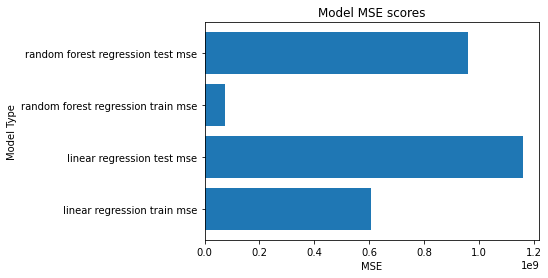

In [42]:
mseScores = np.array([linearTrainMSE,linearTestMSE,treeTrainMSE,treeTestMSE])
plt.figure()
plt.barh(finalScoreSeries.index,finalScoreSeries)
plt.xlabel("MSE")
plt.ylabel("Model Type")
plt.title("Model MSE scores")
plt.savefig("../images/MSEScores.png")